**CNN model**

In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import torch
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import random

import cv2
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

<ipython-input-4-34a20171edf9>:23: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


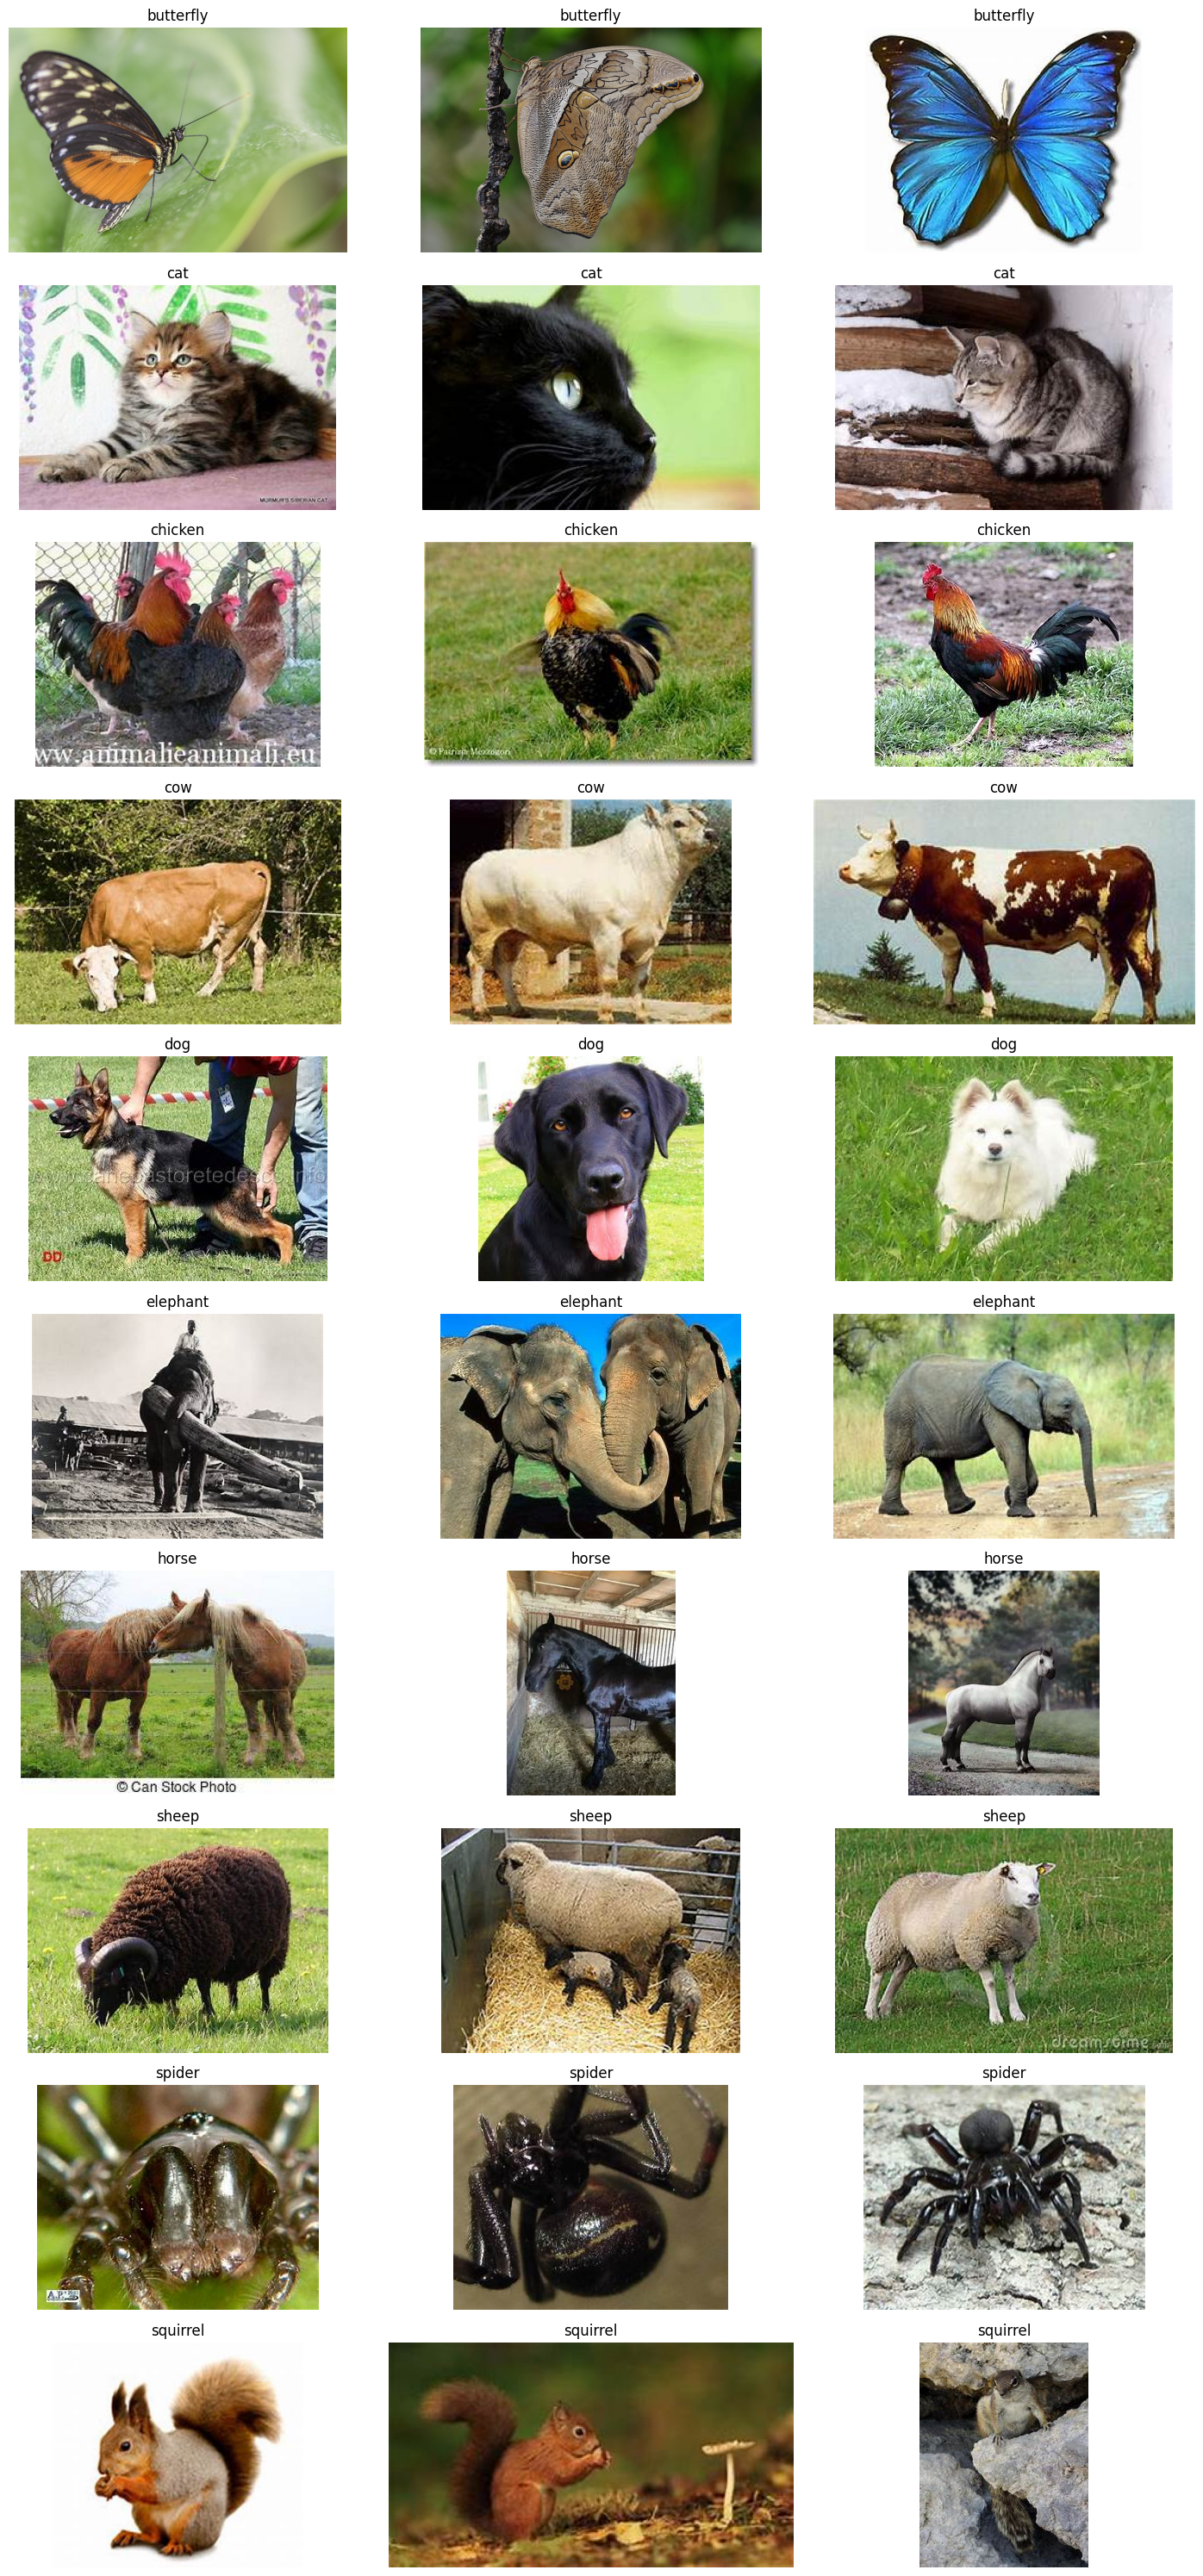

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the directory containing the images
base_directory = '/content/drive/MyDrive/animals10'

# Categories
categories = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, len(categories) * 3))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    random_images = random.sample(image_files, 3)

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)

plt.tight_layout()
plt.show()

In [ ]:
# create test and train files
train_dir = '/content/drive/MyDrive/animals10_split/train'
test_dir = '/content/drive/MyDrive/animals10_split/test'

# show catagories
print("Categories:", categories)

Categories: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [ ]:
# new path to train and test
train_directory = '/content/drive/MyDrive/animals10_split/train'
test_directory = '/content/drive/MyDrive/animals10_split/test'

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(r'/content/drive/MyDrive/animals10_split/train', image_size = (150,150), batch_size=32)

Found 20954 files belonging to 10 classes.


In [ ]:
test = tf.keras.utils.image_dataset_from_directory(r'/content/drive/MyDrive/animals10_split/test', image_size = (150,150), batch_size=32)

Found 5245 files belonging to 10 classes.


In [ ]:

train_iterator = train.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

In [ ]:
batch = train_iterator.next()

In [ ]:
batch[1]

array([1, 8, 7, 7, 2, 5, 0, 1, 8, 4, 8, 0, 4, 4, 9, 1, 6, 2, 4, 2, 4, 1,
       2, 1, 4, 8, 5, 8, 3, 8, 4, 7], dtype=int32)

In [ ]:
batch_test = test_iterator.next()

In [ ]:
len(batch), len(batch_test)

(2, 2)

In [ ]:
batch[0].shape

(32, 150, 150, 3)

In [ ]:
batch_test[0].shape

(32, 150, 150, 3)

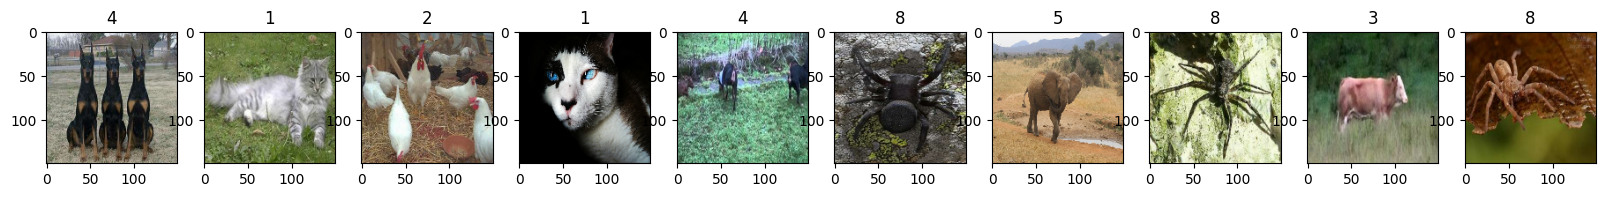

In [ ]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
offset = 20
for idx, img in enumerate(batch[0][offset:offset+10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][offset+idx])

As we can see above the following numbers match the following catagories:

In [ ]:
print("max:" , batch[0].max(), " and min: ", batch[0].min())

max: 255.0  and min:  0.0


In [ ]:
train = train.map(lambda x, y: (x / 255.0, y))

In [ ]:
test = test.map(lambda x, y: (x / 255.0, y))

In [ ]:
train.as_numpy_iterator().next()[0].max(), train.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [ ]:
train_size = int(len(train)*0.8)
val_size = int(len(train)*0.2)

In [ ]:
print(train_size, val_size)

524 131


In [ ]:
train_new = train.take(train_size)
val = train.skip(train_size).take(val_size)

In [ ]:
# Number of batches * 32 images
len(train_new), len(val), len(test)

(524, 131, 164)

In [ ]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))


    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()


    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [ ]:
log_dir = '/content/drive/MyDrive/animals10_split/log'

In [ ]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Combine the TensorBoard callback with the EarlyStopping callback
callbacks = [callback, early_stopping]


In [ ]:
model= tf.keras.Sequential([
    # First layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Second layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,367,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,425,226 (9.25 MB)

 Trainable params: 2,425,226 (9.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_new, epochs=5, validation_data = val, callbacks=[callback])

Epoch 1/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 131s 240ms/step - accuracy: 0.3260 - loss: 1.9341 - val_accuracy: 0.5475 - val_loss: 1.3263
Epoch 2/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 122s 233ms/step - accuracy: 0.5782 - loss: 1.2585 - val_accuracy: 0.6075 - val_loss: 1.1623
Epoch 3/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 141s 232ms/step - accuracy: 0.6852 - loss: 0.9530 - val_accuracy: 0.6001 - val_loss: 1.2541
Epoch 4/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 141s 230ms/step - accuracy: 0.7673 - loss: 0.6802 - val_accuracy: 0.5922 - val_loss: 1.4214
Epoch 5/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 119s 228ms/step - accuracy: 0.8468 - loss: 0.4420 - val_accuracy: 0.6075 - val_loss: 1.5716


In [ ]:
model.save('my_model.keras')

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

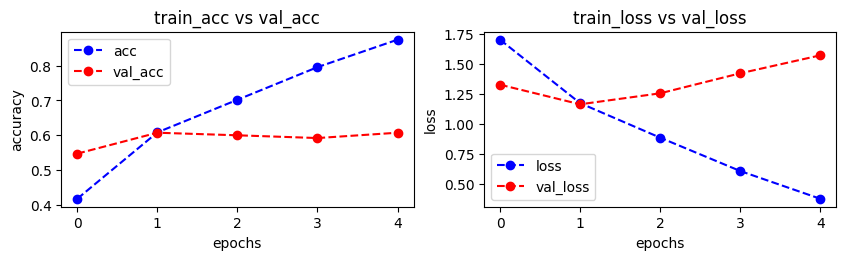

In [ ]:
plot_accuracy_loss(history)

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model.predict(X, batch_size=32)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 10)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

In [ ]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9806, Recall: 0.9643, Accuracy:0.6078


In [ ]:
# Use the appropriate evaluation metrix for your task (accuracy, precision, recall)
model_loss, model_accuracy = model.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.6042 - loss: 1.5650
Test Loss: 1.543394684791565, Test Accuracy: 0.6078169941902161


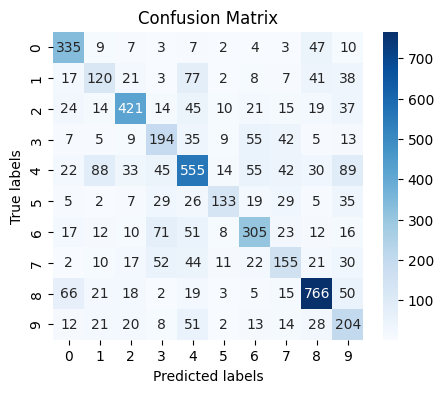

In [ ]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**improve with VGG model**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

# Load the VGG16 base model
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers in the base model
for layer in base_vgg.layers:
    layer.trainable = False

In [ ]:
# Create the head model
x = Flatten()(base_vgg.output)
output = Dense(10, activation='softmax')(x)


In [ ]:
model_vgg = Model(inputs=base_vgg.input, outputs=output)

In [ ]:
model_vgg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          81,930 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,796,618 (56.44 MB)

 Trainable params: 81,930 (320.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_model_vgg = model_vgg.fit(train_new, epochs=5, validation_data = val, callbacks=[callback])

Epoch 1/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 145s 260ms/step - accuracy: 0.6635 - loss: 1.0268 - val_accuracy: 0.7936 - val_loss: 0.6350
Epoch 2/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 125s 238ms/step - accuracy: 0.8392 - loss: 0.4884 - val_accuracy: 0.8156 - val_loss: 0.5720
Epoch 3/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 123s 235ms/step - accuracy: 0.8798 - loss: 0.3650 - val_accuracy: 0.8172 - val_loss: 0.5751
Epoch 4/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 143s 237ms/step - accuracy: 0.9126 - loss: 0.2796 - val_accuracy: 0.7996 - val_loss: 0.6742
Epoch 5/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 127s 243ms/step - accuracy: 0.9258 - loss: 0.2338 - val_accuracy: 0.8227 - val_loss: 0.5890


In [ ]:
model_vgg.save('vgg_basic_model.h5')

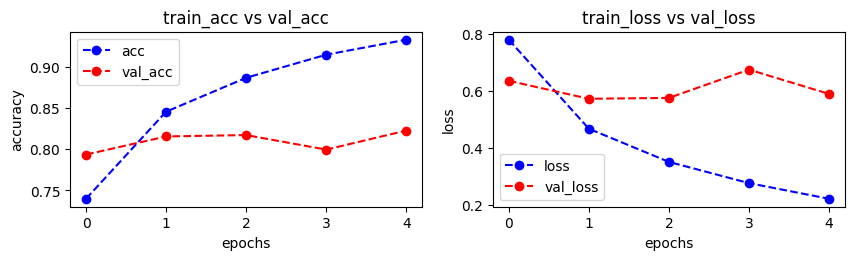

In [ ]:
plot_accuracy_loss(history_model_vgg)

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg.predict(X, batch_size=32)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 10)
    acc.update_state(y_true_one_hot, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

In [ ]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9905, Recall: 0.9936, Accuracy:0.8242


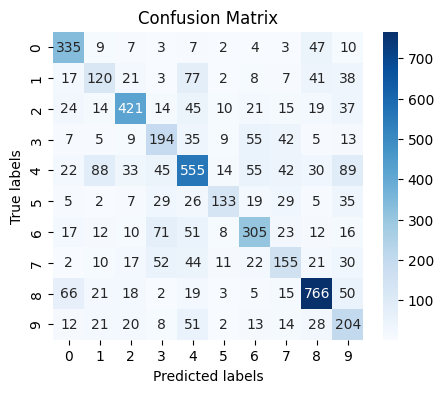

In [ ]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import time

while True:
    time.sleep(60)
